# Linear Regression with k-Fold Cross Validation

In k-Fold cross validation, the whole dataset is divided into roughly equal k folds or sections, where the model is trained on (k-1) folds and validated on the remaining fold. In this way, k models are trained and evaluated as every fold among k acts as a validation set. Finally the performance of all the models is compared and the most suitable one is picked. 

The choice of k in k-fold cross-validation involves a trade-off between bias, variance, and computational cost. For most applications, a value of k between 5 and 10 is a good starting point. The specific choice can be adjusted based on the dataset size and available computational resources:

- For smaller datasets, consider using a larger k to make the most out of limited data. (k=10 or k=m, where m = No. of training examples)
- For larger datasets, smaller k values are often sufficient and more computationally efficient. (k=5)
- Always consider the computational cost, especially for very large datasets, and balance it against the need for accurate performance estimation.

In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
import numpy as np
from sklearn import metrics

In [2]:
df = pd.read_csv('datasets/HousingData.csv')

In [3]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN,36.2


In [4]:
df_cleaned = df.dropna()
df_cleaned

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
5,0.02985,0.0,2.18,0.0,0.458,6.430,58.7,6.0622,3,222,18.7,394.12,5.21,28.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499,0.17783,0.0,9.69,0.0,0.585,5.569,73.5,2.3999,6,391,19.2,395.77,15.10,17.5
500,0.22438,0.0,9.69,0.0,0.585,6.027,79.7,2.4982,6,391,19.2,396.90,14.33,16.8
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9


In [5]:
X = df_cleaned.drop(columns=['MEDV'])
y = df_cleaned['MEDV']

In [6]:
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94
5,0.02985,0.0,2.18,0.0,0.458,6.430,58.7,6.0622,3,222,18.7,394.12,5.21


In [7]:
y.head()

0    24.0
1    21.6
2    34.7
3    33.4
5    28.7
Name: MEDV, dtype: float64

In [8]:
X_main, X_holdout, y_main, y_holdout = train_test_split(X, y, test_size=0.2, random_state=11)
X_main = X_main.to_numpy()
y_main = y_main.to_numpy()
y_holdout = y_holdout.to_numpy()

In [9]:
X_main.shape

(315, 13)

In [10]:
X_holdout.shape

(79, 13)

In [11]:
k = 10 # 10 folds
kf = KFold(k, shuffle=True, random_state=42)
fold = 0
best_model = None
best_fold = 0
r2 = 0
best_model_r2 = float('-inf')
best_model_mae = float('inf')
mm  = MinMaxScaler()
best_model_mm = None
for train_idx, test_idx in kf.split(X_main):
    # train_idx and test_idx are the arrays like: [1,2,3,4] which contains indices of the passed array X_main
    fold += 1
    print(f"Fold: {fold}")
    X_train = X_main[train_idx]
    y_train = y_main[train_idx]
    X_val = X_main[test_idx]
    y_val = y_main[test_idx]
    mm.fit(X_train)
    X_train = mm.transform(X_train)
    X_val = mm.transform(X_val)
    model = tf.keras.Sequential([
        tf.keras.Input(shape= (X_train.shape[1],) ),
        tf.keras.layers.Dense(units=1)  # Output layer with 1 neuron (for regression)
])
    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.SGD(learning_rate=2.))
    model.fit(X_train,y_train,validation_data=(X_val,y_val), batch_size=10000, epochs=100, verbose=0)
    # Measure this fold's MAE
    error = model.evaluate(X_val, y_val, verbose=0)
    pred = model.predict(X_val, verbose=0) 
    r2 = r2_score(y_val, pred)
    if r2 > best_model_r2:
        best_model = model
        best_fold = fold
        best_model_mae = error
        best_model_r2 = r2
        best_model_mm = mm
    print(f"Fold MAE: {error}")
    print(f"Fold R2 Score: {r2}\n")
X_holdout = best_model_mm.transform(X_holdout)
pred_holdout = best_model.predict(X_holdout, verbose=0)
loss_holdout = best_model.evaluate(X_holdout, y_holdout, verbose=0)
# Compute the R^2 score
r2_holdout = r2_score(y_holdout, pred_holdout)
print('Best fold: ', best_fold)
print('Best model params:\n')
print(f'R2 score for cross validation set: {best_model_r2}')
print(f'R2 score for hold out set: {r2_holdout}')
print(f'Loss for cross validation set (MAE): {best_model_mae}') 
print(f'Loss for hold out set (MAE): {loss_holdout}') 


Fold: 1
Fold MAE: 2.5596282482147217
Fold R2 Score: 0.787256978674969

Fold: 2
Fold MAE: 3.0381908416748047
Fold R2 Score: 0.6603415509323799

Fold: 3
Fold MAE: 3.849215030670166
Fold R2 Score: 0.5012057946808421

Fold: 4
Fold MAE: 3.87019944190979
Fold R2 Score: 0.6213149755517644

Fold: 5
Fold MAE: 3.5826187133789062
Fold R2 Score: 0.7611726195430318

Fold: 6
Fold MAE: 5.645949840545654
Fold R2 Score: 0.4596431540403305

Fold: 7
Fold MAE: 3.523800849914551
Fold R2 Score: 0.6944336703852656

Fold: 8
Fold MAE: 2.731203317642212
Fold R2 Score: 0.6383826885169633

Fold: 9
Fold MAE: 3.6760997772216797
Fold R2 Score: 0.45521098439655483

Fold: 10
Fold MAE: 3.345728635787964
Fold R2 Score: 0.6492486631675731



c:\Users\chaud\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


Best fold:  1
Best model params:

R2 score for cross validation set: 0.787256978674969
R2 score for hold out set: 0.6331489197752176
Loss for cross validation set (MAE): 2.5596282482147217
Loss for hold out set (MAE): 4.061331272125244


#### Plotting Predicted vs Actual Value of Linear Regression Model

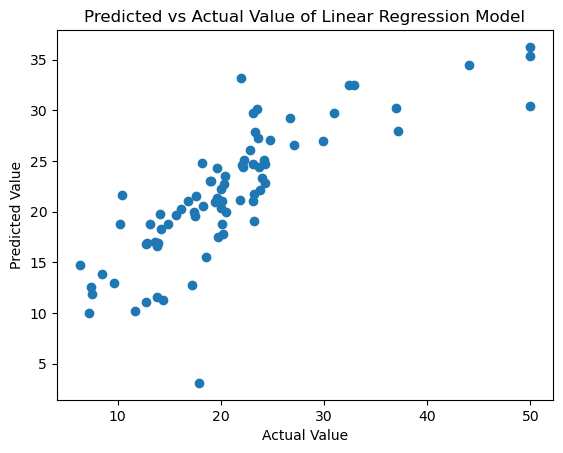

In [12]:
plt.scatter(y_holdout, pred_holdout)
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('Predicted vs Actual Value of Linear Regression Model')
plt.show()